In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [2]:
data_dir="C:/Users/shars/Downloads/Crops"

In [3]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=32, label_mode='categorical')

Found 22787 files belonging to 15 classes.


In [4]:
classes=data.class_names
classes

['Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
# Normalize the dataset
data = data.map(lambda x, y: (x / 255.0, y))

In [6]:
len(data)

713

In [5]:
train_size = 500
val_size = 63
test_size = 150

In [6]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [7]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,354,927 (43.32 MB)

 Trainable params: 11,354,927 (43.32 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Train the model with validation
history = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 404s 803ms/step - accuracy: 0.4493 - loss: 1.7164 - val_accuracy: 0.7173 - val_loss: 0.9176
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 432s 864ms/step - accuracy: 0.7929 - loss: 0.6048 - val_accuracy: 0.8249 - val_loss: 0.5146
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 846s 2s/step - accuracy: 0.8838 - loss: 0.3326 - val_accuracy: 0.8770 - val_loss: 0.3743
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.9362 - loss: 0.1905 - val_accuracy: 0.8785 - val_loss: 0.4267
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - accuracy: 0.9549 - loss: 0.1316 - val_accuracy: 0.8874 - val_loss: 0.4242
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - accuracy: 0.9616 - loss: 0.1098 - val_accuracy: 0.8973 - val_loss: 0.3765
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.9759 - loss: 0.0708 - val_accuracy: 0.8780 - val_loss: 0.4623
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - accuracy: 0.9760 - loss: 0.0678 - va

In [13]:
# Save the model
model.save("saved_model/")


In [12]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f"Test accuracy: {test_accuracy}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 75s 426ms/step - accuracy: 0.9094 - loss: 0.3619
Test accuracy: 0.9107105135917664


In [9]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy

In [10]:
pre=Precision()
rec=Recall()
acc=CategoricalAccuracy()

In [11]:
x_test=[]
y_test=[]
for batch in test.as_numpy_iterator():
    x,y=batch
    y=y.astype(int)
    x_test.append(x)
    y_test.append(y)

In [12]:
x_test=np.concatenate(x_test)
y_test=np.concatenate(y_test)

In [14]:
yhat=model.predict(x_test)

150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 383ms/step


In [15]:
pre.update_state(y_test,yhat)
rec.update_state(y_test,yhat)
acc.update_state(y_test,yhat)

In [16]:
pre.result().numpy(),rec.result().numpy(),acc.result().numpy()

(0.9675994, 0.96394885, 0.9645777)

In [17]:
y_test_labels=np.argmax(y_test,axis=1)
y=np.argmax(yhat,axis=1)

In [18]:
from sklearn.metrics import confusion_matrix as cm

In [19]:
matrix=cm(y_test_labels,y)
import pandas as pd
df=pd.DataFrame(matrix)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,207,1,0,0,1,0,2,1,0,7,0,0,0,0,0
1,1,312,0,1,7,0,0,1,0,0,0,0,0,0,0
2,0,0,183,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,204,1,1,0,7,0,1,0,0,1,0,0
4,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,428,2,0,0,0,0,0,2,0,0
6,0,0,0,1,0,11,192,3,0,3,0,2,0,0,0
7,0,0,2,4,2,1,4,396,0,4,0,2,0,0,1
8,0,0,0,1,0,0,2,3,196,11,6,3,1,4,0
9,2,1,2,1,0,2,2,0,0,330,0,6,3,1,0


In [20]:
from sklearn.metrics import classification_report
report = classification_report(y_test_labels, y)

In [21]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       219
           1       0.99      0.97      0.98       322
           2       0.98      1.00      0.99       183
           3       0.96      0.94      0.95       216
           4       0.64      1.00      0.78        25
           5       0.96      0.99      0.97       433
           6       0.93      0.91      0.92       212
           7       0.96      0.95      0.96       416
           8       0.99      0.86      0.92       227
           9       0.92      0.94      0.93       350
          10       0.95      0.98      0.96       333
          11       0.91      0.96      0.93       277
          12       0.99      0.99      0.99      1124
          13       0.94      0.93      0.94        86
          14       1.00      0.98      0.99       348

    accuracy                           0.96      4771
   macro avg       0.94      0.96      0.95      4771
weighted avg       0.97   

In [22]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test_labels, y, average='weighted')
f1

0.9647635149086388

In [23]:
import seaborn as sns

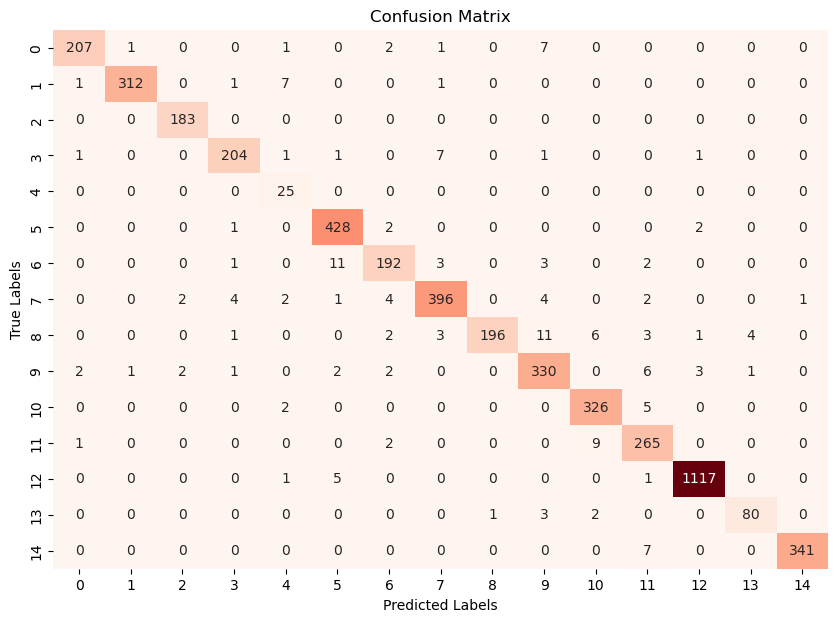

In [24]:
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()